In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix
import warnings
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics as mt
import statsmodels.api as sm
from time import time
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from yellowbrick.model_selection import FeatureImportances
from yellowbrick.classifier import PrecisionRecallCurve
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix

In [2]:
ccdefault=pd.read_csv('../data//UCI_Credit_Card.csv')
ccdefault.rename(columns={'default.payment.next.month':'DEFAULT'},inplace=True)
ccdefault.rename(columns={'PAY_0':'PAY_1'},inplace=True)

In [3]:
mcc = ccdefault.copy()
# Y Response variable dataframe
mcc_Y = mcc['DEFAULT']
# Features with no predictive features with respect to resposne variable
mcredit = mcc.drop(['DEFAULT'],axis=1)
# Create inci_X Explanatory Variables DF to support the individual models
mcc_X = mcredit
mcc_X_rf = mcredit.copy()

In [15]:
cc = ccdefault.copy() # taking a copy in memory
if 'DEFAULT' in cc:
    y = cc['DEFAULT'].values
    del cc['DEFAULT']
    del cc['ID']
    del cc['BILL_AMT1']
    del cc['BILL_AMT2']
    del cc['BILL_AMT3']
    del cc['BILL_AMT4']
    del cc['BILL_AMT5']
    del cc['BILL_AMT6']
    X = cc.values
num_cv_iterations = 10
num_instances = len(y)
cv_object = StratifiedShuffleSplit(n_splits = num_cv_iterations,
test_size = 0.20, train_size = 0.80, random_state=11)
cv_object.get_n_splits(X, y)
print(cv_object)
for train_index, test_index in cv_object.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

StratifiedShuffleSplit(n_splits=10, random_state=11, test_size=0.2,
            train_size=0.8)
TRAIN: [28976 29616 20315 ...  6063 16283 15621] TEST: [ 6669  6830 16516 ... 16163  1990  7999]
TRAIN: [11237  9898 17028 ...  1265   611  7250] TEST: [ 4174 19421 15502 ... 19995  6124 25090]
TRAIN: [23721 14143  5492 ...  4346  5119 23351] TEST: [21778  4074 19546 ...   941 14061 13584]
TRAIN: [19706  2009 13912 ...  3924 20112 21366] TEST: [ 7136 15572 21097 ... 24126  8440  7078]
TRAIN: [ 5794  1831 15948 ... 18673 15962 17274] TEST: [17565 28798 29978 ... 10151 11434 21212]
TRAIN: [24432   681  7983 ...  9657 11016 29778] TEST: [ 3610 22489   947 ... 11546 29007 11635]
TRAIN: [18133 16950 15079 ... 14554  2548 19876] TEST: [23255 21894  2453 ... 29769 11817   917]
TRAIN: [27925 20338  1447 ... 20551 15325  9624] TEST: [29430 17123 24994 ... 14719  7335 17180]
TRAIN: [28761  7353 27082 ...  7560  9115 24317] TEST: [ 4505 25791  7014 ... 24831  5266 14377]
TRAIN: [18713 24326 28260 ...  

In [16]:
scl_obj = StandardScaler()
scl_obj.fit(X_train) # find scalings for each column that make this zero mean and unit std
# the line of code above only looks at training data to get mean and std and we can use it 
# to transform new feature data

X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) # apply those means and std to the test set (without snooping at the test set values)


X_train_scaled1 = scl_obj.fit_transform(X_train) # apply to training
X_test_scaled1 = scl_obj.fit_transform(X_test) # apply those means and std to the test set (without snooping at the test set values)



## Modeling and Evaluation 3 

### Random Forest model 

We need to create some more  models by adjusting n_estimators and max_depth parameters. Also we need to  create one models with class_weight='balanced'

The time it takes to fit and predict for iteration 0  is 0.7075839042663574 
classification report for iteration 0 


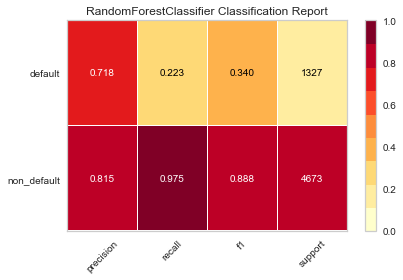

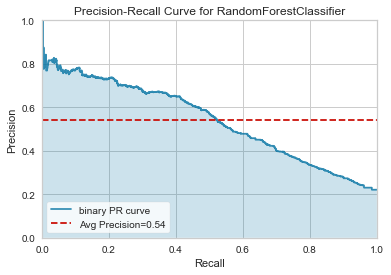

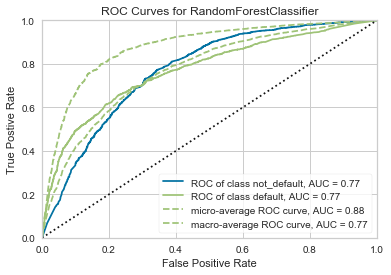

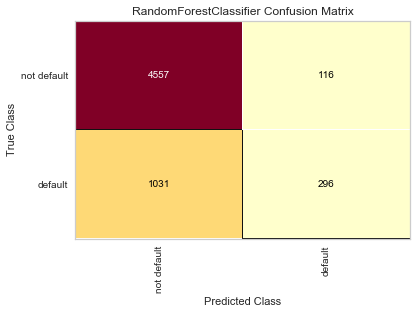

The time it takes to fit and predict for iteration 1  is 0.7338659763336182 
classification report for iteration 1 


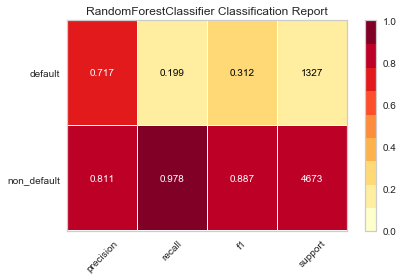

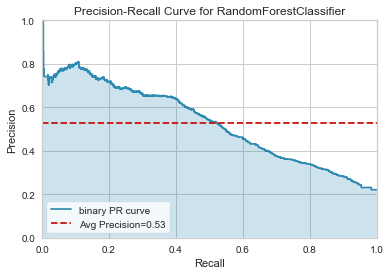

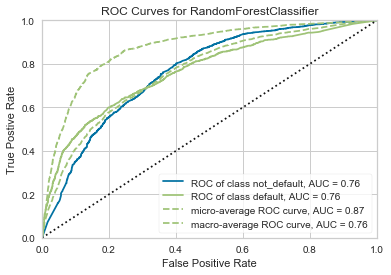

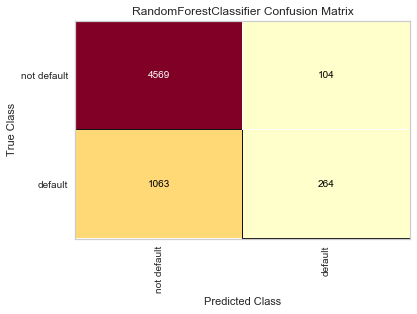

The time it takes to fit and predict for iteration 2  is 0.6950640678405762 
classification report for iteration 2 


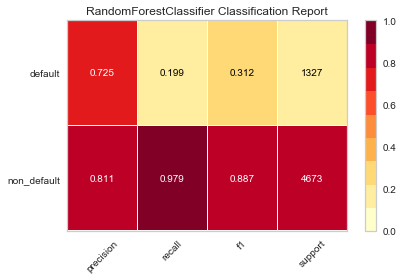

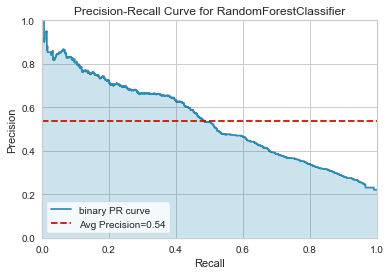

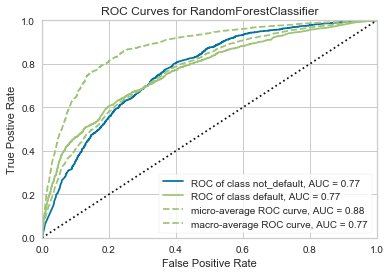

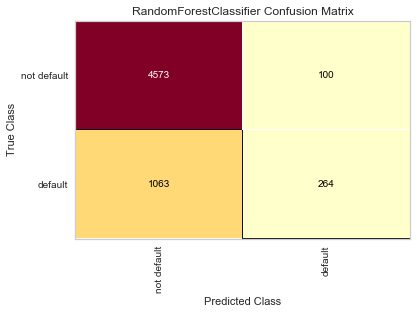

The time it takes to fit and predict for iteration 3  is 0.6741456985473633 
classification report for iteration 3 


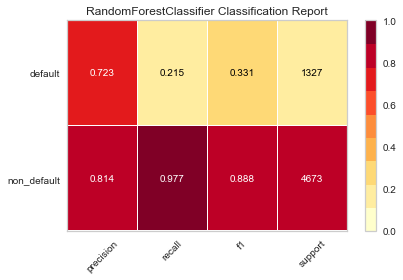

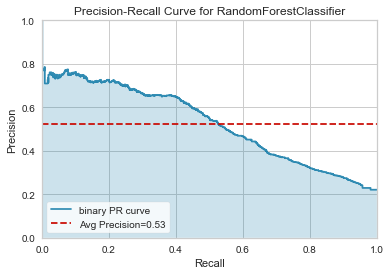

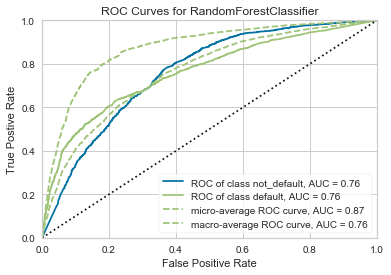

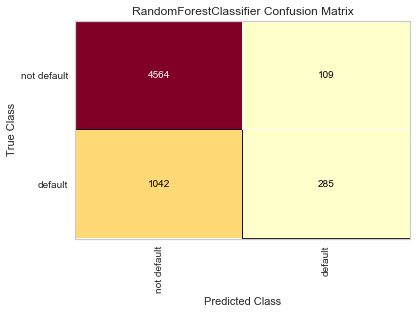

The time it takes to fit and predict for iteration 4  is 0.6695530414581299 
classification report for iteration 4 


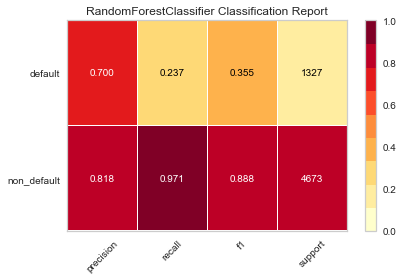

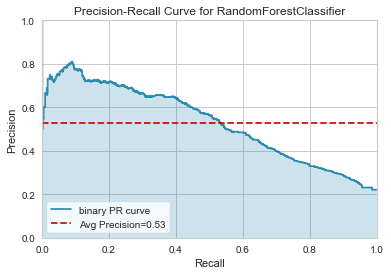

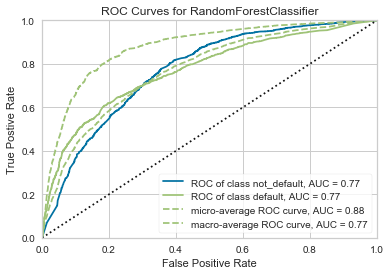

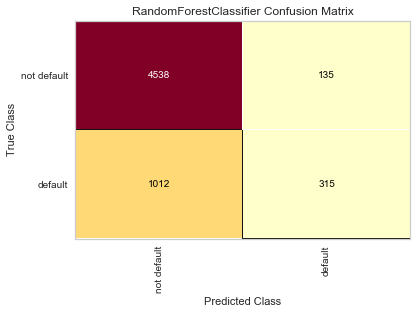

The time it takes to fit and predict for iteration 5  is 0.7031512260437012 
classification report for iteration 5 


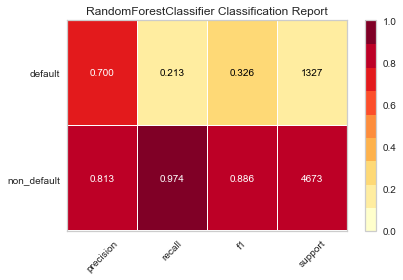

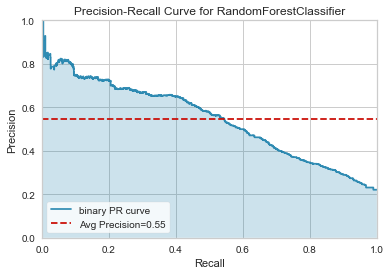

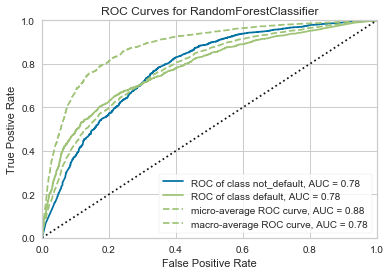

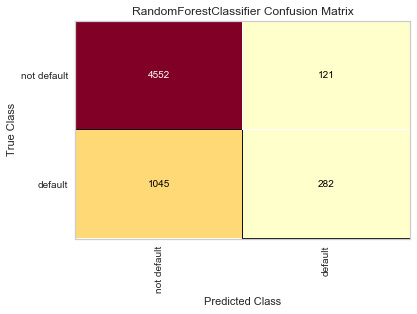

The time it takes to fit and predict for iteration 6  is 0.7005040645599365 
classification report for iteration 6 


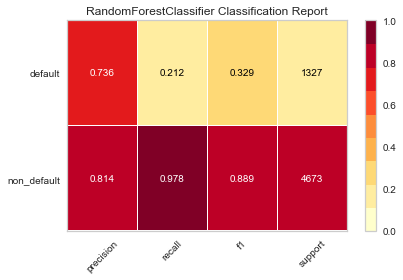

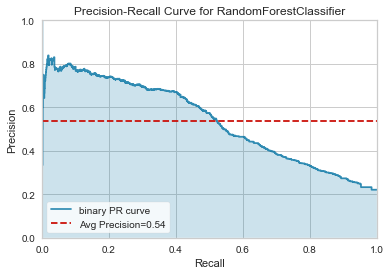

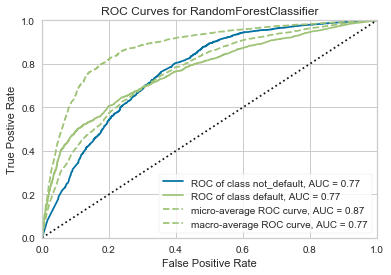

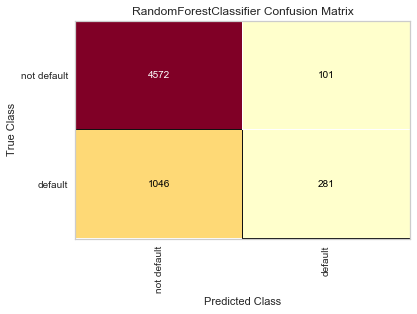

The time it takes to fit and predict for iteration 7  is 0.7211949825286865 
classification report for iteration 7 


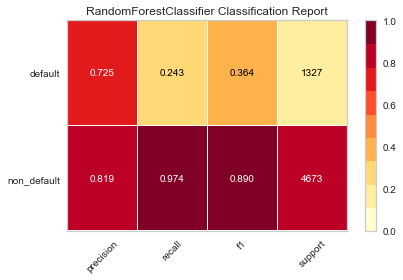

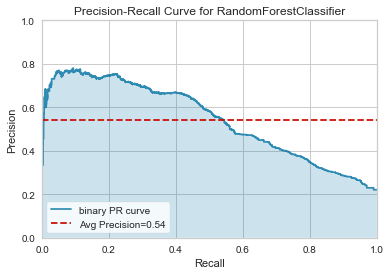

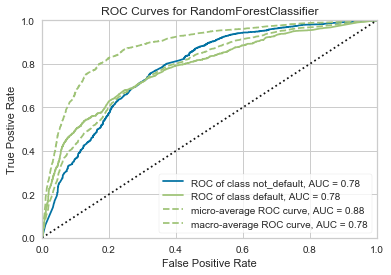

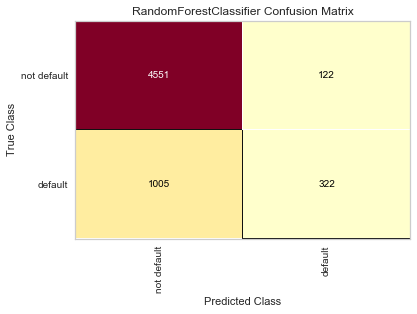

The time it takes to fit and predict for iteration 8  is 0.729093074798584 
classification report for iteration 8 


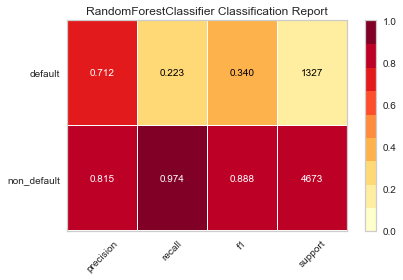

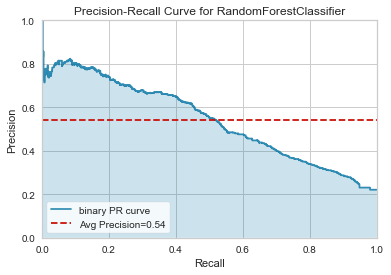

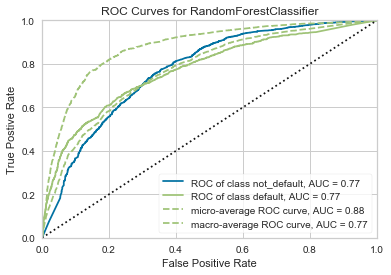

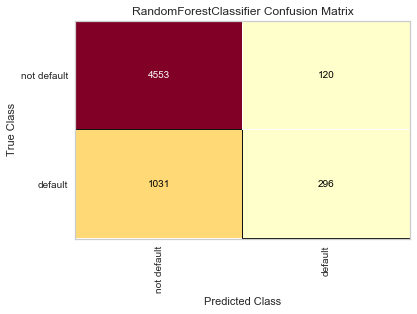

The time it takes to fit and predict for iteration 9  is 0.7054200172424316 
classification report for iteration 9 


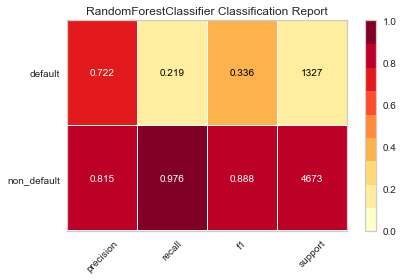

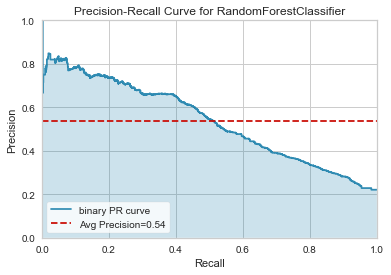

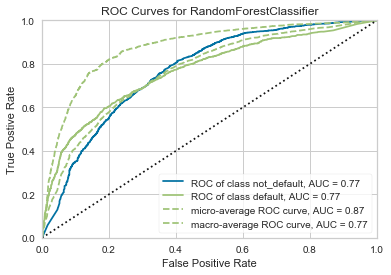

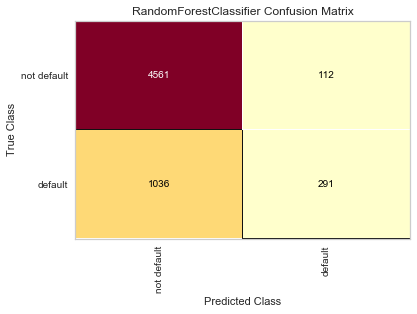

In [17]:
iter_num=0
times_rec=[]
decision_tree_classifiers = dict()
random_forest_classifiers = dict()

for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices] 
    X_test = X[test_indices]
    y_test = y[test_indices]
    
     #we count the time in executing the logistic regression
    t0 = time()
    random_forest = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)

    random_forest.fit(X_train,y_train)  # train object
    y_hat = random_forest.predict(X_test) # get test set precitions
    
    t1=time()
    diff=np.array([t1-t0])
    
    print ("The time it takes to fit and predict for iteration {}  is {} ".format(iter_num, diff[0])) 
    times_rec=np.append(times_rec,diff)
    

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print ("classification report for iteration {} ".format(iter_num))

    rf_cl_reporter = ClassificationReport(random_forest, classes=['non_default' , 'default'], support=True)

    rf_cl_reporter.fit(X_train, y_train)        # Fit the visualizer and the model
    rf_cl_reporter.score(X_test, y_test)        # Evaluate the model on the test data
    rf_cl_reporter.show()   
    
    pr_curve = PrecisionRecallCurve(random_forest)
    pr_curve.fit(X_train, y_train)
    pr_curve.score(X_test, y_test)
    pr_curve.show()
    
    
    roc_curve = ROCAUC(random_forest, classes=["not_default", "default"])
    roc_curve.fit(X_train, y_train)        # Fit the training data to the visualizer
    roc_curve.score(X_test, y_test)        # Evaluate the model on the test data
    roc_curve.show() 
    

    cm = ConfusionMatrix(random_forest, classes=['not default' , 'default'])
    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(X_train, y_train)
    # To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
    # and then creates the confusion_matrix from scikit-learn.
    cm.score(X_test, y_test)
    # How did we do?
    cm.show()
     
    iter_num+=1
    

###  Decision Tree classifiers 

We need to create some more  models by adjusting n_estimators and max_depth parameters. Also we need to  create one models with class_weight='balanced'

The time it takes to fit and predict for iteration 0  is 0.26459288597106934 
classification report for iteration 0 


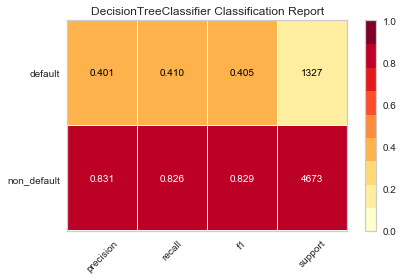

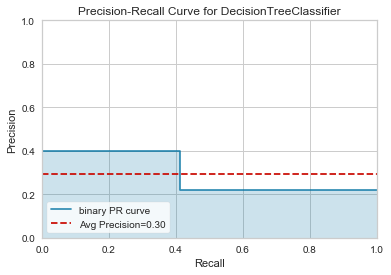

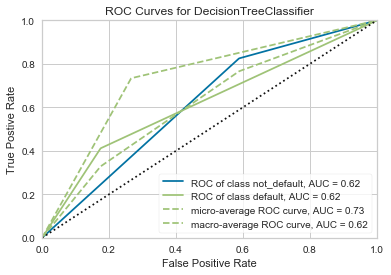

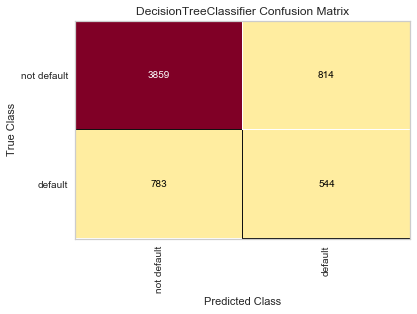

The time it takes to fit and predict for iteration 1  is 0.24838995933532715 
classification report for iteration 1 


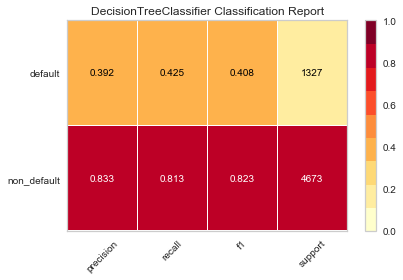

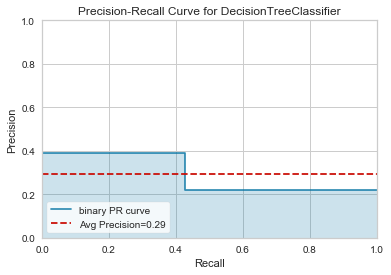

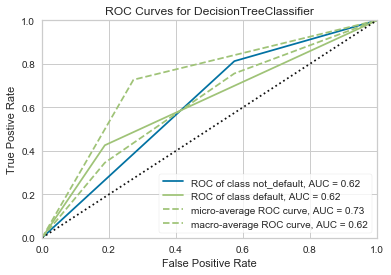

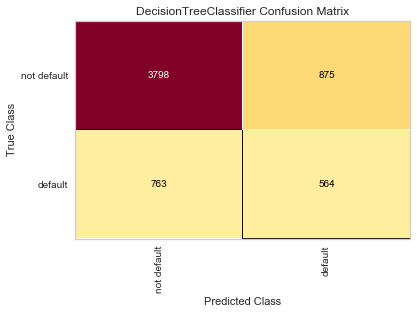

The time it takes to fit and predict for iteration 2  is 0.24048209190368652 
classification report for iteration 2 


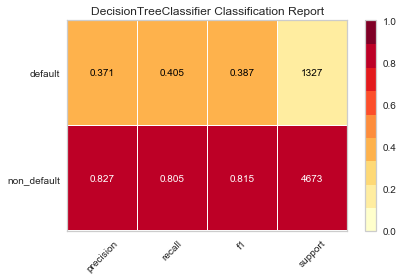

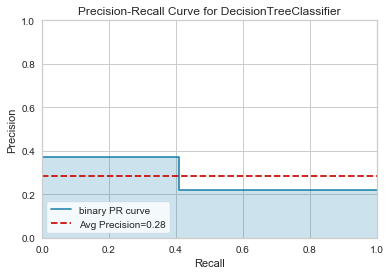

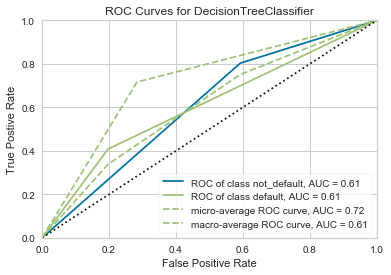

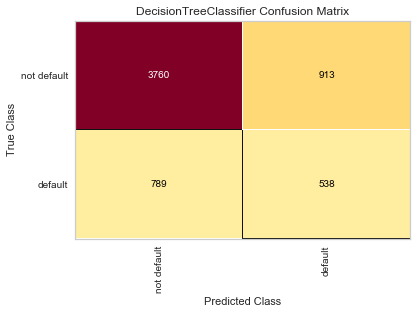

The time it takes to fit and predict for iteration 3  is 0.25858402252197266 
classification report for iteration 3 


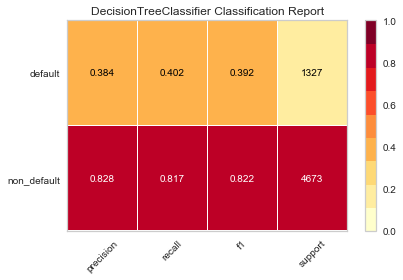

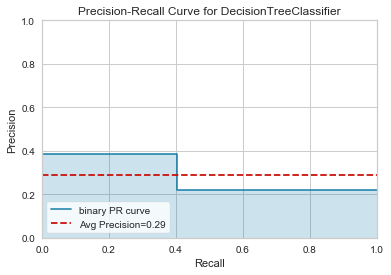

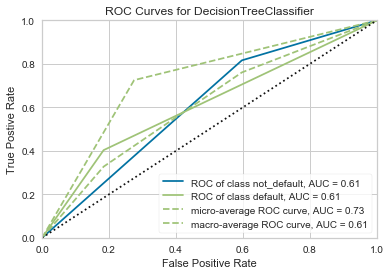

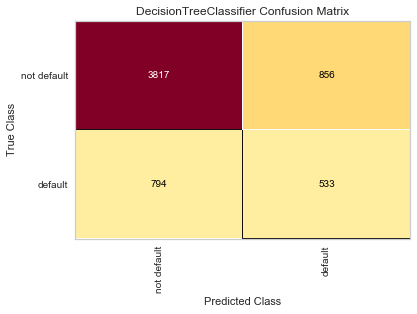

The time it takes to fit and predict for iteration 4  is 0.25154614448547363 
classification report for iteration 4 


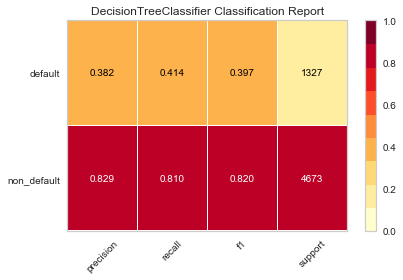

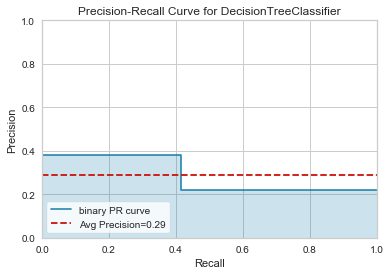

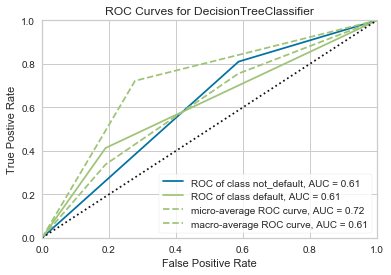

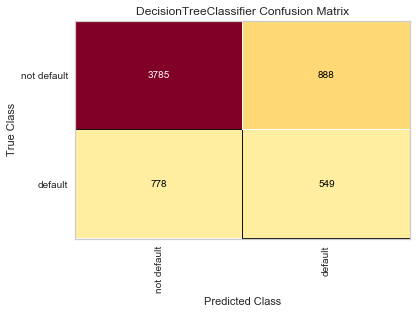

The time it takes to fit and predict for iteration 5  is 0.2596700191497803 
classification report for iteration 5 


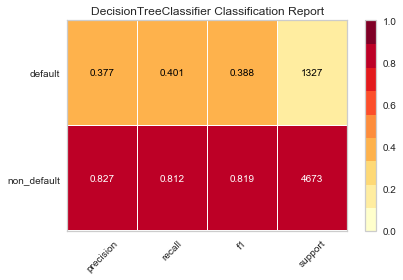

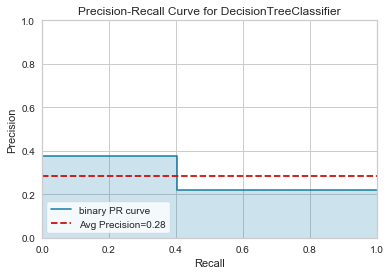

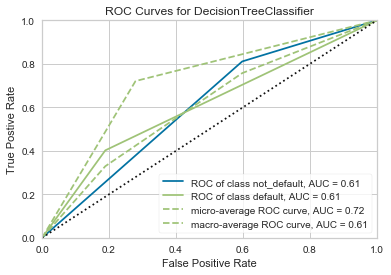

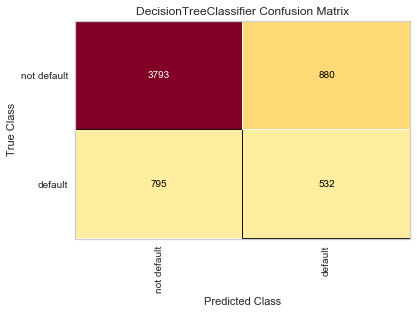

The time it takes to fit and predict for iteration 6  is 0.2555389404296875 
classification report for iteration 6 


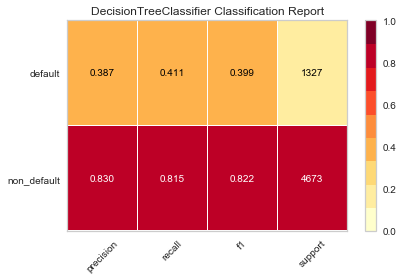

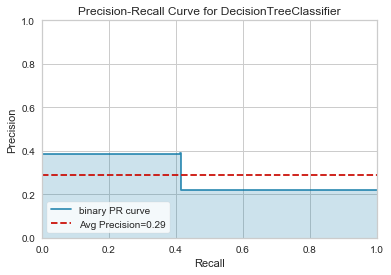

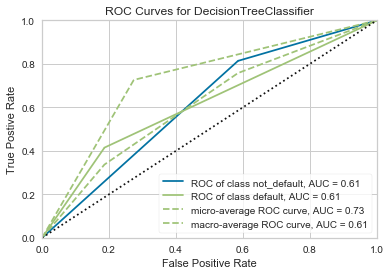

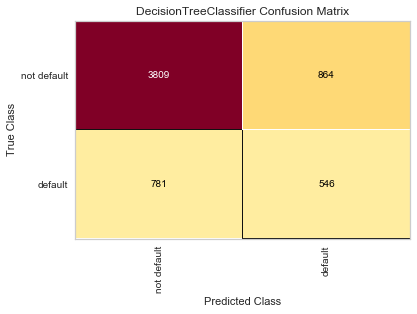

The time it takes to fit and predict for iteration 7  is 0.23079299926757812 
classification report for iteration 7 


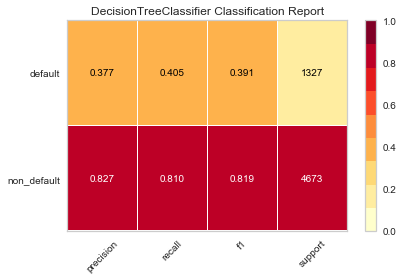

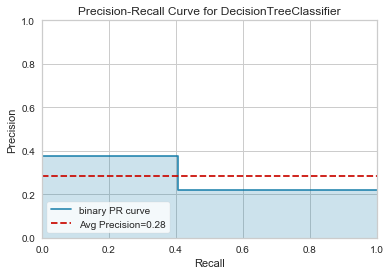

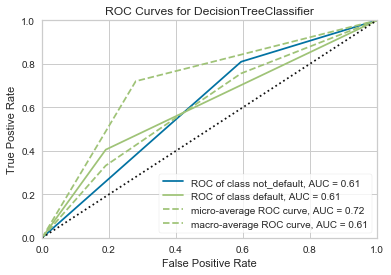

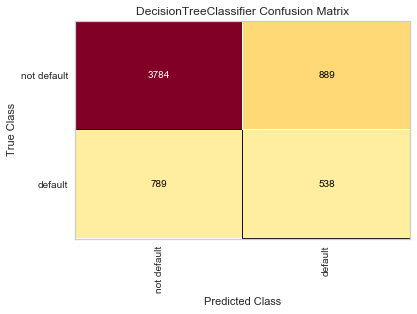

The time it takes to fit and predict for iteration 8  is 0.2590169906616211 
classification report for iteration 8 


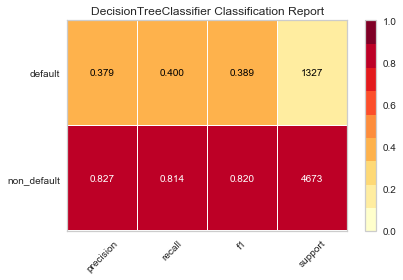

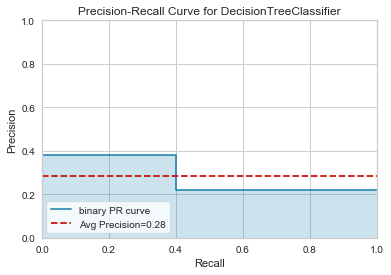

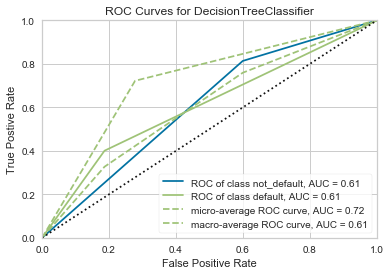

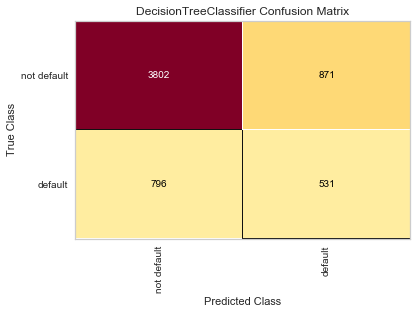

The time it takes to fit and predict for iteration 9  is 0.259127140045166 
classification report for iteration 9 


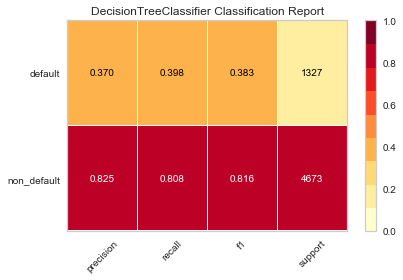

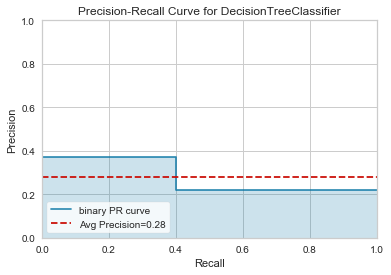

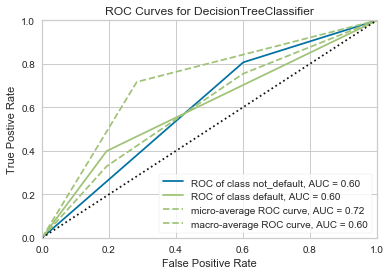

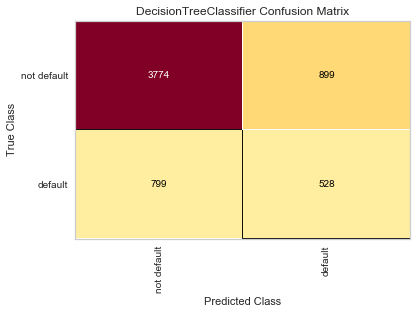

In [18]:
iter_num=0
times_rec=[]
decision_tree_classifiers = dict()
random_forest_classifiers = dict()
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
     #we count the time in executing the logistic regression
    t0 = time()
     
    decision_tree = DecisionTreeClassifier()

    decision_tree.fit(X_train,y_train)  # train object
    y_hat = decision_tree.predict(X_test) # get test set precitions
    
    t1=time()
    diff=np.array([t1-t0])
    
    print ("The time it takes to fit and predict for iteration {}  is {} ".format(iter_num, diff[0])) 
    times_rec=np.append(times_rec,diff)
    

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print ("classification report for iteration {} ".format(iter_num))

     
    
    dt_cl_reporter = ClassificationReport(decision_tree, classes=['non_default' , 'default'], support=True)

    dt_cl_reporter.fit(X_train, y_train)        # Fit the visualizer and the model
    dt_cl_reporter.score(X_test, y_test)        # Evaluate the model on the test data
    dt_cl_reporter.show()  
    
    pr_curve = PrecisionRecallCurve(decision_tree)
    pr_curve.fit(X_train, y_train)
    pr_curve.score(X_test, y_test)
    pr_curve.show()
    
    roc_curve = ROCAUC(decision_tree, classes=["not_default", "default"])

    roc_curve.fit(X_train, y_train)        # Fit the training data to the visualizer
    roc_curve.score(X_test, y_test)        # Evaluate the model on the test data
    roc_curve.show() 
    
    cm = ConfusionMatrix(decision_tree, classes=['not default' , 'default'])
    # Fit fits the passed model. This is unnecessary if you pass the visualizer a pre-fitted model
    cm.fit(X_train, y_train)
    # To create the ConfusionMatrix, we need some test data. Score runs predict() on the data
    # and then creates the confusion_matrix from scikit-learn.
    cm.score(X_test, y_test)
    # How did we do?
    cm.show()
    
        
    iter_num+=1
    

### KNN 
TBD 

## Modeling and Evaluation 4
We can give some details from the graphs created in previous section and explain those 

### Random Forest 


### Decision Tree 

### KNN 

## Modeling and Evaluation 5


### Random Forest 

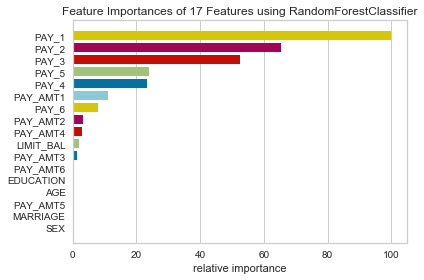

In [12]:
viz = FeatureImportances(random_forest, labels = cc.columns)
viz.fit(X_train_scaled,y_train)
viz.show()

### Decision Tree 

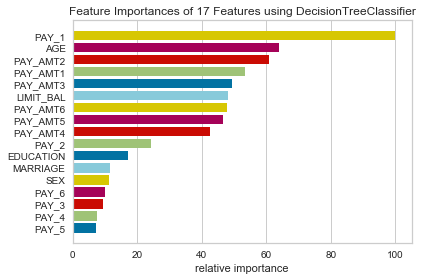

In [13]:
viz = FeatureImportances(decision_tree, labels = cc.columns)
viz.fit(X_train_scaled,y_train)
viz.show()

### KNN 

## Modeling and Evaluation 6

Following is a Comparison of Decision Tree and Random forest classifiers with same date. We are using error estimates to compare two models. The error estimates should follow Gaussian distribution. We calculate mean and standard error using the formula discussed in the class. 
<TODO add image and formula >
    We are caclulating confidence interval for error differences to figure out if the differences are significant
  We can add similar test for knn , decision tree and knn and random forest comparison 


### Decision Tree and Random Forest Comparision based on error rate 

In [8]:
iter_num=0
times_rec=[]
error_rec= [] 
for train_indices, test_indices in cv_object.split(X,y): 
    X_train = X[train_indices]
    y_train = y[train_indices]
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    decision_tree = DecisionTreeClassifier()
    decision_tree.fit(X_train,y_train) # train object
    
    random_forest = RandomForestClassifier(n_estimators=100, max_depth=2,
                             random_state=0)
    random_forest.fit(X_train,y_train) 
    
    y_hat_dt = decision_tree.predict(X_test) 
    y_hat_rf = random_forest.predict(X_test) 

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc_dt = mt.accuracy_score(y_test,y_hat_dt)
    acc_rf = mt.accuracy_score(y_test,y_hat_rf)
    error_rec.append(acc_dt - acc_rf)

    iter_num+=1

print(error_rec)

d_bar = sum(error_rec)/len(error_rec)
siqma_squared = sum((error_rec - d_bar))/(5-1)
print(d_bar)
print(siqma_squared)

from scipy import stats
import math

confidence_interval = ( d_bar + (1/math.sqrt(4))*stats.t.isf(.975, 4),  d_bar - (1/math.sqrt(4))*stats.t.isf(.975, 4))
print(confidence_interval)

[-0.08199999999999996, -0.08450000000000002, -0.08966666666666667, -0.08583333333333332, -0.08749999999999991]
-0.08589999999999998
0.0
(-1.4741225525988995, 1.3023225525988993)


As we can see above tht zero is a possible value for 95% confidence interval it means that we can't reject the null hypothesis that both the models have no difference in their error rate with 95% confidence.

##  KNN  and Random Forest Comparision based on error rate 